# CS3920 Assignment 2

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

wine = load_wine()


wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(wine.data, wine.target, random_state=2408)

svm = SVC()
cv_scores = cross_val_score(svm, wine_X_train, wine_y_train)
general_score = np.mean(cv_scores)
print(f"Estimated Generalisation Accuracy of Default SVM: {np.mean(general_score)}")

Estimated Generalisation Accuracy of Default SVM: 0.6994301994301994


In [2]:
svm.fit(wine_X_train, wine_y_train)
error = 1 - svm.score(wine_X_test, wine_y_test)
print(f"Estimated Error Rate: {1 - general_score}")
print(f"Actual Error Rate:    {error}")

Estimated Error Rate: 0.30056980056980065
Actual Error Rate:    0.4222222222222223


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "Normalizer": Normalizer()
}

param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.001, 0.01, 0.1, 1, 10, 100]
}

def getBestEstimator(X_train, y_train, X_test, y_test, output):
    results = {}
    best_estimator = None
    best_score = -1
    
    for n, scaler in scalers.items():
        print(f"Testing {n}...")
        pipeline = Pipeline([
            ('scaler', scaler),
            ('svc', SVC())
        ])
        grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        results[n] = {
            "best_params": grid.best_params_,
            "best_cv_score": grid.best_score_,
            "best_accuracy": grid.score(X_test, y_test)
        }
        
        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_estimator = grid.best_estimator_
    
    if output:
        for n in results.keys():
            print(f"{n} Scores:")
            print("Best Params:   ", results[n].get("best_params"))
            print("Best CV Score: ", results[n].get("best_cv_score"))
            print("Best Accuracy: ", results[n].get("best_accuracy"))
            print()
        
    return best_estimator

best_wine = getBestEstimator(wine_X_train, wine_y_train, wine_X_test, wine_y_test, True)
print(best_wine)



Testing StandardScaler...
Testing MinMaxScaler...
Testing RobustScaler...
Testing Normalizer...
StandardScaler Scores:
Best Params:    {'svc__C': 1, 'svc__gamma': 0.1}
Best CV Score:  0.97008547008547
Best Accuracy:  1.0

MinMaxScaler Scores:
Best Params:    {'svc__C': 1, 'svc__gamma': 0.1}
Best CV Score:  0.9774928774928775
Best Accuracy:  1.0

RobustScaler Scores:
Best Params:    {'svc__C': 1, 'svc__gamma': 0.01}
Best CV Score:  0.9777777777777779
Best Accuracy:  1.0

Normalizer Scores:
Best Params:    {'svc__C': 100, 'svc__gamma': 100}
Best CV Score:  0.9324786324786325
Best Accuracy:  0.9555555555555556

Pipeline(steps=[('scaler', RobustScaler()), ('svc', SVC(C=1, gamma=0.01))])


In [ ]:
import numpy as np 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

class CrossConformalPredictor:
    def __init__(self, X_train, y_train, X_test, y_test, model,
                 n_splits=5, alpha=0.05, random_state=2408):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.n_splits = n_splits
        self.alpha = alpha
        self.random_state = random_state

    def _get_fold_conformity_scores(self):
        """
            Compute conformity scores using cross-validation on the training set.
        """
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        fold_data = []

        for rest_idx, fold_idx in kf.split(self.X_train):
            X_rest, X_fold = self.X_train[rest_idx], self.X_train[fold_idx]
            y_rest, y_fold = self.y_train[rest_idx], self.y_train[fold_idx]

            self.model.fit(X_rest, y_rest)

            # conformity for calibration samples
            fold_scores = self.model.decision_function(X_fold)
            calibration_conformity = fold_scores[np.arange(len(y_fold)), y_fold]

            test_scores = self.model.decision_function(self.X_test)

            fold_data.append({
                "calibration": calibration_conformity,
                "test": test_scores
            })

        return fold_data

    def _calculate_p_values(self, fold_data, test_index):
        """
            Compute p-values for a test point.
        """
        n_classes = fold_data[0]["test"].shape[1]
        n = len(self.X_train)

        p_values = np.zeros(n_classes)

        for y in range(n_classes):
            count = 0
            for fold in fold_data:
                alpha_yk = fold["test"][test_index, y]
                count += np.sum(fold["calibration"] <= alpha_yk)

            p_values[y] = (count + 1) / (n + 1)

        return p_values

    def predict(self):
        """
            Makes predictions on the test set using conformity scores and p-values       
        """
        fold_data = self._compute_fold_scores()

        prediction_sets = []
        p_values_all = []

        for i in range(len(self.X_test)):
            p_vals = self._p_values_for_test_point(fold_data, i)
            p_values_all.append(p_vals)

            prediction_sets.append(np.where(p_vals > self.alpha)[0])

        self.prediction_sets = prediction_sets
        self.p_values = p_values_all

        return prediction_sets, p_values_all

    def get_validity(self):
        """
            Fraction of test points where true label is inside prediction set.
        """
        correct = 0
        for i in range(len(self.y_test)):
            if self.y_test[i] in self.prediction_sets[i]:
                correct += 1
        return correct / len(self.y_test)

    def average_false_p_value(self):
        """
            Calculates the mean of p-values assigned to incorrect classes.
        """
        false_p_vals = []
        n_classes = len(self.p_values[0])

        for i in range(len(self.y_test)):
            true_label = self.y_test[i]
            for c in range(n_classes):
                if c != true_label:
                    false_p_vals.append(self.p_values[i][c])

        return np.mean(false_p_vals)
    
    def calibration_curve(self):
        """
            Plots the calibration curve of the model
        """
        true_p_values = []
        n_test = len(self.y_test)

        for i in range(n_test):
            true_label = self.y_test[i]
            true_p_values.append(self.p_values[i][true_label])

        true_p_values = np.array(true_p_values)
        alpha_levels = np.zeros(100)
        error_rates = np.zeros(100)

        for k in range(100):
            alpha_levels[k] = k/100
            errors = 0
            for j in range(n_test):
                if true_p_values[j] <= alpha_levels[k]:
                        errors += 1
                error_rates[k] = errors / n_test


        plt.title("Calibration Graph")
        plt.xlabel("Significance Level")
        plt.ylabel("Error Rate")
        plt.plot(alpha_levels, error_rates, label="Calibration Curve")
        plt.plot(alpha_levels, alpha_levels, linestyle="--", label="Optimal Calibration")
        plt.show()
        

## Testing on the Wine Dataset

[array([0.00746269, 0.00746269, 0.21641791]), array([0.00746269, 0.79104478, 0.00746269]), array([0.23880597, 0.02238806, 0.00746269]), array([0.49253731, 0.00746269, 0.00746269]), array([0.00746269, 0.48507463, 0.00746269]), array([0.00746269, 0.00746269, 0.78358209]), array([0.68656716, 0.00746269, 0.00746269]), array([0.00746269, 0.00746269, 0.32835821]), array([0.76119403, 0.00746269, 0.00746269]), array([0.00746269, 0.18656716, 0.00746269]), array([0.00746269, 0.18656716, 0.00746269]), array([0.1641791 , 0.00746269, 0.00746269]), array([0.94776119, 0.00746269, 0.00746269]), array([0.00746269, 0.18656716, 0.00746269]), array([0.79104478, 0.00746269, 0.00746269]), array([0.00746269, 0.58208955, 0.00746269]), array([0.00746269, 0.93283582, 0.00746269]), array([0.00746269, 0.52985075, 0.00746269]), array([0.00746269, 0.18656716, 0.00746269]), array([0.96268657, 0.00746269, 0.00746269]), array([0.00746269, 0.00746269, 0.64179104]), array([0.94776119, 0.00746269, 0.00746269]), array([0.

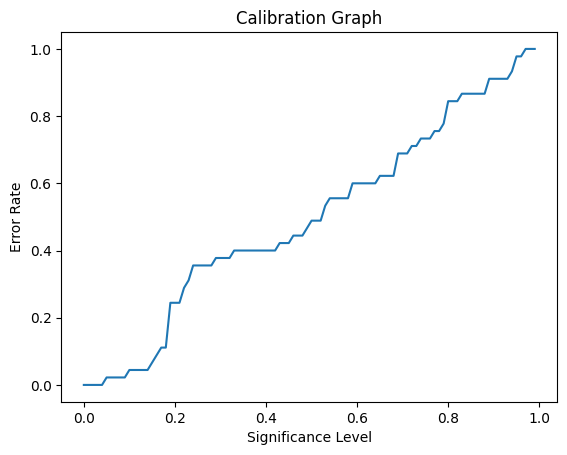

In [12]:
cc_predictor = CrossConformalPredictor(wine_X_train, wine_y_train, wine_X_test, wine_y_test, best_wine)

predictions, p_values = cc_predictor.predict()
print(p_values)
validity = cc_predictor.get_validity()
false_p = cc_predictor.average_false_p_value()

print(f"Validity:              {validity}")
print(f"Average False P-Value: {false_p}")

cc_predictor.calibration_curve()

## Testing on the USPS (zip) Dataset

In [22]:
zip_X_train = np.genfromtxt("zip.train", delimiter=" ", usecols=np.arange(1, 256), dtype=float)
zip_X_test = np.genfromtxt("zip.test", delimiter=" ", usecols=np.arange(1, 256), dtype=float)

zip_y_train = np.genfromtxt("zip.train", usecols=0).astype(int)
zip_y_test = np.genfromtxt("zip.test", usecols=0).astype(int)

best_zip = getBestEstimator(zip_X_train, zip_y_train, zip_X_test, zip_y_test, True)


Testing StandardScaler...
Testing MinMaxScaler...
Testing RobustScaler...
Testing Normalizer...
StandardScaler Scores:
Best Params:    {'svc__C': 10, 'svc__gamma': 0.001}
Best CV Score:  0.971333880525869
Best Accuracy:  0.9446935724962631

MinMaxScaler Scores:
Best Params:    {'svc__C': 100, 'svc__gamma': 0.01}
Best CV Score:  0.9744885113072353
Best Accuracy:  0.9481813652217239

RobustScaler Scores:
Best Params:    {'svc__C': 100, 'svc__gamma': 0.001}
Best CV Score:  0.8964433425378264
Best Accuracy:  0.8729446935724963

Normalizer Scores:
Best Params:    {'svc__C': 10, 'svc__gamma': 1}
Best CV Score:  0.9786031735286679
Best Accuracy:  0.9491778774289985



Validity:              0.916791230692576
Average False P-Value: 0.003237571407369872


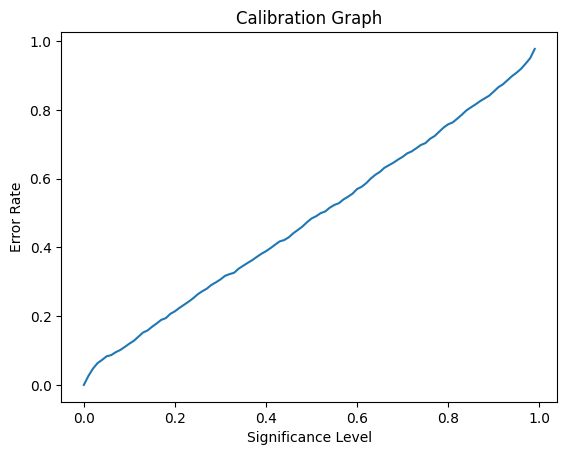

In [25]:
cc_predictor = CrossConformalPredictor(zip_X_train, zip_y_train, zip_X_test, zip_y_test, best_zip)

predictions, p_values = cc_predictor.predict()
validity = cc_predictor.get_validity()
false_p = cc_predictor.average_false_p_value()

print(f"Validity:              {validity}")
print(f"Average False P-Value: {false_p}")

cc_predictor.calibration_curve()